# Models Testing - Neural Network

In [1]:
from imports import *
import pipeline_functions as pipeline_functions
%matplotlib inline
import keras.backend as K

## Import datasets processed in previous step

In [2]:
# Reading the Data for train and test.
df=pd.read_hdf(config.df_features_selections, 'df')
df_test=pd.read_hdf(config.df_test_features_selections, 'df')

## Auxiliary function to build mlp for binary classification

In [3]:
def create_2class_mlp(input_dim, hidden_layers, hl_activation="relu", optimizer="sgd", metrics=["accuracy"], seed=0):
    # Create a sequential model
    model = Sequential()
    # Add layers 
    if hidden_layers is None:    
        # Single-layer perceptron
        model.add(layers.Dense(units=1,                               
                               input_dim=input_dim,
                               kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed),
                               bias_initializer=tf.keras.initializers.GlorotNormal(seed=seed),
                               activation='sigmoid'))
    else:   
        # Multi-layer perceptron
        for i, hl in enumerate(hidden_layers):
            model.add(layers.Dense(units=hl, 
                                   input_dim=input_dim if i==0 else hidden_layers[i-1],                                   
                                   kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed),
                                   bias_initializer=tf.keras.initializers.GlorotNormal(seed=seed),
                                   activation=hl_activation))

        # Add last (output) layer
        model.add(layers.Dense(units=1, 
                               input_dim=hidden_layers[-1],                                   
                               kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed),
                               bias_initializer=tf.keras.initializers.GlorotNormal(seed=seed),
                               activation='sigmoid'))        
    
    # Compile the model before return
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
    #model.compile(loss=f1_loss, optimizer=optimizer, metrics=metrics)
    
    return model

## Prepare data

In [4]:
X = df.drop(columns=[config.y_column])
y = df[config.y_column]

X_test = df_test.drop(columns=[config.y_column])
y_test = df_test[config.y_column]

In [5]:
missing_values = SimpleImputer(strategy='median')
X = missing_values.fit_transform(X,y)
X_test = missing_values.transform(X_test)

scaler = pipeline_functions.CustomScaler(strategy=pipeline_functions.CustomScalerType.STANDARD)
X = scaler.fit_transform(X,y)
X_test = scaler.transform(X_test)


In [6]:
# Calculate the class weights
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weight = {c: cw for c, cw in zip(np.unique(y), class_weight)}
for c, w in class_weight.items():
    print('Weight of class {}: {:.2f}'.format(c, w))

Weight of class 0: 0.50
Weight of class 1: 74.73


## Train models

In [7]:
architectures = {"x5x-01": {"hidden_layers": [5], "optimizer": optimizers.SGD(0.01)}, 
                 "x5x-001": {"hidden_layers": [5], "optimizer": optimizers.SGD(0.001)}, 
                 "x5x5x-01": {"hidden_layers": [5, 5], "optimizer": optimizers.SGD(0.01)},
                 "x5x5x-001": {"hidden_layers": [5, 5], "optimizer": optimizers.SGD(0.001)}}

metrics_ = [metrics.Precision(name="precision"), 
            metrics.Recall(name="recall"),
            metrics.AUC(name='AUPRC', curve='PR')]

seed = 0
models, history = {}, {}
epochs, batch_size = 200, len(X)
for arch_name, arch in architectures.items():
    start = time.time()
    models[arch_name] = create_2class_mlp(X.shape[1], arch["hidden_layers"], 
                                          optimizer=arch["optimizer"], 
                                          metrics=metrics_, seed=seed)    
    history[arch_name] = models[arch_name].fit(X, y, epochs=epochs, batch_size=batch_size,
                                               class_weight=class_weight, 
                                               validation_data=(X_test, y_test), 
                                               verbose=0)    
    print("Training time: {:.4f}s".format(time.time() - start))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-04 22:15:50.224971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 22:15:50.225146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-04 22:15:50.538862: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-04 22:15:50.787295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-04 22:15:53.803013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training time: 185.9683s


2022-12-04 22:18:56.659045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-04 22:18:58.022056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training time: 195.5309s


2022-12-04 22:22:12.186211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-04 22:22:16.175591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training time: 246.0974s


2022-12-04 22:26:18.312127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-04 22:26:22.660257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training time: 537.2560s


## Assess the models

In [8]:
# Concatenates history callbacks
df_hist = {} 
for h_key, h_val in history.items():
    df_hist[h_key] = pd.DataFrame.from_dict(h_val.history)
    df_hist[h_key]["Epoch"] = np.arange(1, len(df_hist[h_key]) + 1, 1)
   
df_hist = pd.concat(df_hist).reset_index(level=0, inplace=False)
df_hist.rename(columns = {'level_0': 'Architecture'}, inplace=True)

Plots training and validation measures.

In [9]:
# Choose the color palette for seaborn
sns.set_style("whitegrid")
my_palette = ["darkgrey", "darkred"]
my_palette = sns.color_palette(my_palette)

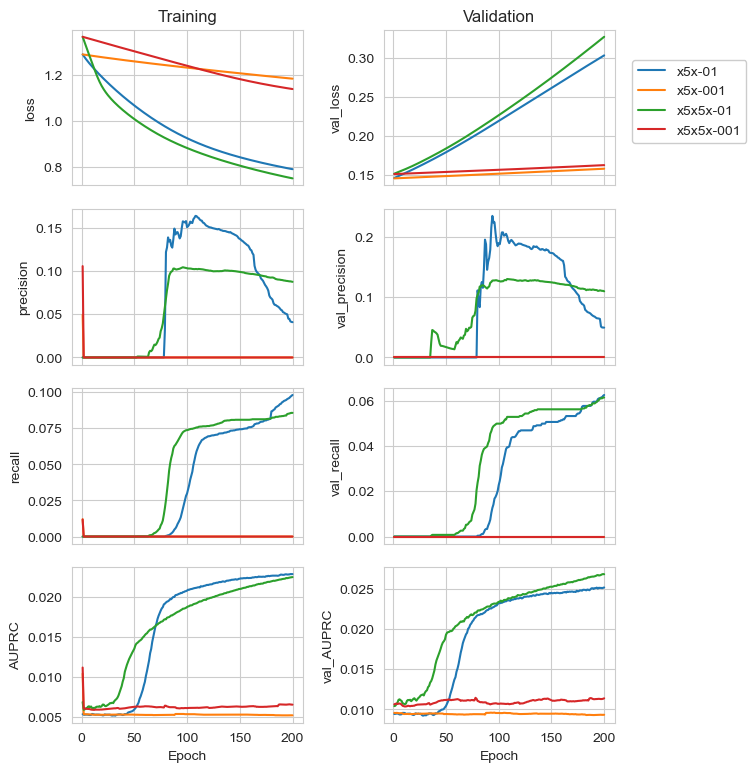

In [10]:
# Plots
fig, axes = plt.subplots(len(metrics_) + 1, 2, figsize=(7, 9), sharey=False, sharex=True)
plt.subplots_adjust(hspace=0.15, wspace=0.35)
for mi, metric in enumerate(["loss"] + [m.name for m in metrics_]):
    # Loss
    sns.lineplot(data=df_hist, x="Epoch", y=metric, hue="Architecture", ax=axes[mi, 0], legend=False)
    sns.lineplot(data=df_hist, x="Epoch", y=f'val_{metric}', hue="Architecture", ax=axes[mi, 1],
                 legend=True if mi==0 else False)
    axes[mi, 0].set_ylabel(metric)
    
axes[0, 1].legend(framealpha=1.0, loc=(1.075, 0.275))
axes[0, 0].set_title("Training")
axes[0, 1].set_title("Validation")
plt.show()

For each probability threshold, computes the precision and recall values of **trained** models.

In [11]:
prc = {}
for m_name, m_value in models.items():    
    # Compute training and test precision and recall 
    y_pred_train = m_value.predict(X)
    y_pred_val = m_value.predict(X_test)
    precision_train, recall_train, probs_train = precision_recall_curve(y, y_pred_train)
    precision_val, recall_val, probs_val = precision_recall_curve(y_test, y_pred_val)
    prc[m_name] = {"precision": precision_train, "recall": recall_train, "probs": probs_train,
                   "val_precision": precision_val, "val_recall": recall_val, "val_probs": probs_val,}

   79/52746 [..............................] - ETA: 1:43

2022-12-04 22:35:16.015030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   86/52746 [..............................] - ETA: 1:34

2022-12-04 22:39:33.705200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   79/52746 [..............................] - ETA: 1:42

2022-12-04 22:41:39.967912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   68/52746 [..............................] - ETA: 2:00

2022-12-04 22:43:52.745464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7565/7565 [==============================] - 15s 2ms/step


Plots precision-recall curves of **trained** models.

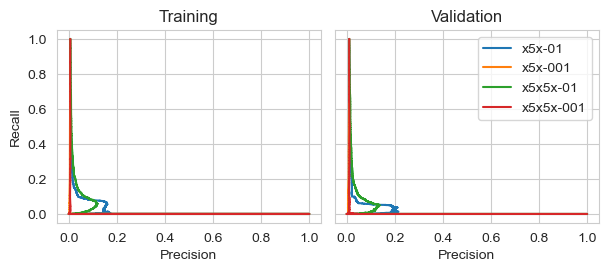

In [12]:
# Plots
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.25, wspace=0.05)
# Plot precision and recall curves    
for mi, m_name in enumerate(prc.keys()):      
    axes[0].plot(prc[m_name]["precision"], prc[m_name]["recall"])
    axes[1].plot(prc[m_name]["val_precision"], prc[m_name]["val_recall"], label=m_name)    
    if mi==0:
        axes[0].set_title("Training")
        axes[1].set_title("Validation")    
        axes[0].set_ylabel("Recall")
        axes[0].set_xlabel("Precision")
        axes[1].set_xlabel("Precision")
        
plt.legend(loc="upper right")

Plots precision and recall as a function of probability threshold (i.e., the decision function).

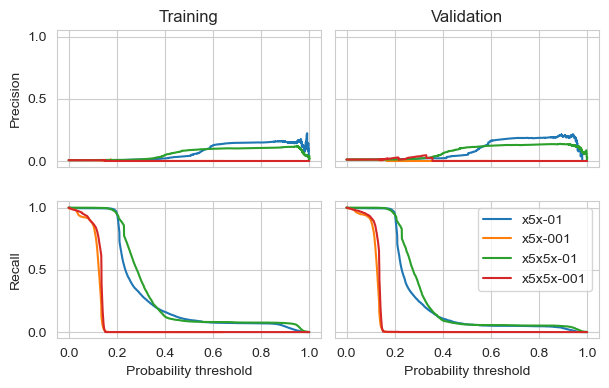

In [13]:
# Plots
fig, axes = plt.subplots(2, 2, figsize=(7, 4), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.25, wspace=0.05)
# Plot precision and recall curves    
for mi, m_name in enumerate(prc.keys()):      
    # Precision
    axes[0, 0].plot(prc[m_name]["probs"], prc[m_name]["precision"][:-1])
    axes[0, 1].plot(prc[m_name]["val_probs"], prc[m_name]["val_precision"][:-1], label=m_name)
    # Recall
    axes[1, 0].plot(prc[m_name]["probs"], prc[m_name]["recall"][:-1])
    axes[1, 1].plot(prc[m_name]["val_probs"], prc[m_name]["val_recall"][:-1], label=m_name)
    if mi==0:
        axes[0, 0].set_title("Training")
        axes[0, 1].set_title("Validation")            
        axes[0, 0].set_ylabel("Precision")
        axes[1, 0].set_ylabel("Recall")
        axes[1, 0].set_xlabel("Probability threshold")
        axes[1, 1].set_xlabel("Probability threshold")
    
plt.legend()

Plots confusion matrices.

7565/7565 [==============================] - 15s 2ms/step


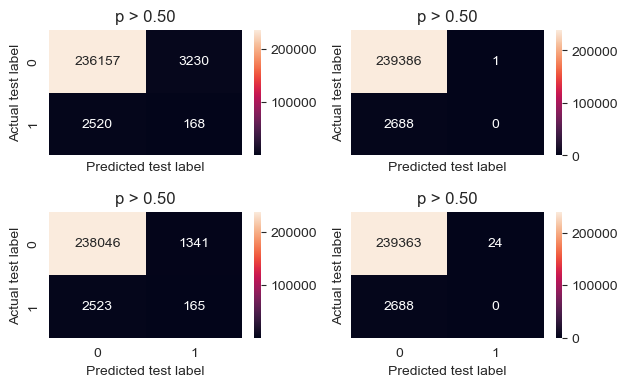

In [14]:
# Threshold
threshold, split = 0.5, "test"
# Plots
fig, axes = plt.subplots(2, 2, figsize=(7, 4), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.45, wspace=0.25)

for i, (m_name, m_value) in enumerate(models.items()): 
    # Compute CM
    y_pred = m_value.predict(X_test if split=="test" else X)
    cm = confusion_matrix(y_test if split=="test" else y, y_pred > threshold)
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt="d", ax=axes.flat[i])
    axes.flat[i].set_title('p > {:.2f}'.format(threshold))
    axes.flat[i].set_ylabel(f'Actual {split} label')
    axes.flat[i].set_xlabel(f'Predicted {split} label')